# Ocean Data Challenge :: Liquidity Provision Strategies on DEXs
Explore how different liquidity provision strategies, such as AMMs, order book-based exchanges, and liquidity pools, have impacted the performance of DEXs over time. Data can be collected from various public blockchain explorers, APIs, and DeFi data aggregators.

### Luca Ordronneau

## Import Librairies

In [1]:
import os
import datetime

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.io as pio
pio.templates.default = "seaborn"

In [2]:
DATADIR = "../data/"
FILTER_DATE = '2021-07-28'

In [3]:
def load_data(filename):
    df = pd.read_csv(os.path.join(DATADIR, filename), index_col=0)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    return df

In [4]:
pair = "usdc_weth" # Can be changed to usdc_usdt
token_0 = pair.split('_')[0].upper()
token_1 = pair.split('_')[1].upper()
pair_upper = pair.upper().replace('_', '/')
token_0, token_1, pair_upper

('USDC', 'WETH', 'USDC/WETH')

# Uniswap V2

In [5]:
df = load_data(f'{pair}_uniswapV2.csv')
df_swaps = load_data(f'swaps_{pair}_uniswapV2.csv')
df_swaps.replace(['0', 0], np.nan, inplace=True)
df_swaps[['amount0_in', 'amount1_in', 'amount0_out', 'amount1_out']] = df_swaps[['amount0_in', 'amount1_in', 'amount0_out', 'amount1_out']].astype(float)

df_burns = load_data(f'burns_{pair}_uniswapV2.csv')
df_burns[['amount0', 'amount1']] = df_burns[['amount0', 'amount1']].astype(float)
df_mints = load_data(f'mints_{pair}_uniswapV2.csv')
df_mints[['amount0', 'amount1']] = df_mints[['amount0', 'amount1']].astype(float)
df_price = load_data(f'eth_usdc_price.csv') 

df_hour = df.groupby(pd.Grouper(key="timestamp", freq="H")).mean()
df_price_hour = df_price.groupby(pd.Grouper(key="timestamp", freq="H")).mean()
df_price_hour = df_price_hour[:-1]

df_burns_hour = df_burns.groupby(pd.Grouper(key="timestamp", freq="H")).agg({'amount0': 'sum', 'amount1': 'sum', 'transaction_hash':'count'})
df_mints_hour = df_mints.groupby(pd.Grouper(key="timestamp", freq="H")).agg({'amount0': 'sum', 'amount1': 'sum', 'transaction_hash':'count'})
df_swaps_hour = df_swaps.groupby(pd.Grouper(key="timestamp", freq="H")).agg({'amount0_in': 'sum', 'amount1_in': 'sum', 'amount0_out': 'sum', 'amount1_out': 'sum', 'transaction_hash':'count'})

df_burns_hour = df_burns_hour[df_burns_hour.index > FILTER_DATE]
df_mints_hour = df_mints_hour[df_mints_hour.index > FILTER_DATE]
df_swaps_hour = df_swaps_hour[df_swaps_hour.index > FILTER_DATE]

## Data Cleaning

In [6]:
def percentage_change(col1,col2):
    return (abs(col2 - col1) / col1)

if pair == "usdc_weth":
    df_hour['USDC_WETH_real_price'] = df_price_hour['usdc_close']
    df_hour['USDC_WETH_change'] = percentage_change(df_price_hour['usdc_close'], df_hour['USDC_WETH_price'])

    df_hour.loc[(df_hour['USDC_WETH_change'] > 0.005), 'USDC_reserve'] = np.nan
    df_hour.loc[(df_hour['USDC_WETH_change'] > 0.005), 'WETH_reserve'] = np.nan
    df_hour.loc[(df_hour['USDC_reserve'] == 0), 'USDC_reserve'] = np.nan
    df_hour.loc[(df_hour['WETH_reserve'] == 0), 'WETH_reserve'] = np.nan

    df_hour = df_hour.interpolate()
    df_hour = df_hour.ffill()
    df_hour = df_hour.bfill()

    df_mints_hour = df_mints_hour.merge(df_hour[["USDC_WETH_real_price"]], left_index=True, right_index=True)
    df_burns_hour = df_burns_hour.merge(df_hour[["USDC_WETH_real_price"]], left_index=True, right_index=True)
    df_swaps_hour = df_swaps_hour.merge(df_hour[["USDC_WETH_real_price"]], left_index=True, right_index=True)

    df_mints_hour["volume"] = (df_mints_hour["amount0"] + (df_mints_hour["amount1"] * df_mints_hour["USDC_WETH_real_price"])) / 10**18
    df_burns_hour["volume"] = (df_burns_hour["amount0"] + (df_burns_hour["amount1"] * df_burns_hour["USDC_WETH_real_price"])) / 10**18

    df_swaps_hour["trading_volume"] = (df_swaps_hour["amount0_in"] + df_swaps_hour["amount1_in"] * df_swaps_hour["USDC_WETH_real_price"] + df_swaps_hour["amount0_out"] + df_swaps_hour["amount1_out"] * df_swaps_hour["USDC_WETH_real_price"]) / 10**18
    df_hour["TVL"] = df_hour['USDC_reserve'] + df_hour['WETH_reserve'] * df_hour['USDC_WETH_real_price']


elif pair == "usdc_usdt":

    df_mints_hour["volume"] = (df_mints_hour["amount0"] + df_mints_hour["amount1"])/ 10**4
    df_burns_hour["volume"] = (df_burns_hour["amount0"] + df_burns_hour["amount1"])/ 10**4
    df_swaps_hour["trading_volume"] = (df_swaps_hour["amount0_in"] + df_swaps_hour["amount1_in"] + df_swaps_hour["amount0_out"] + df_swaps_hour["amount1_out"])/ 10**6
    df_hour["TVL"] = df_hour['USDC_reserve'] + df_hour['USDT_reserve']

## Data Visualisation

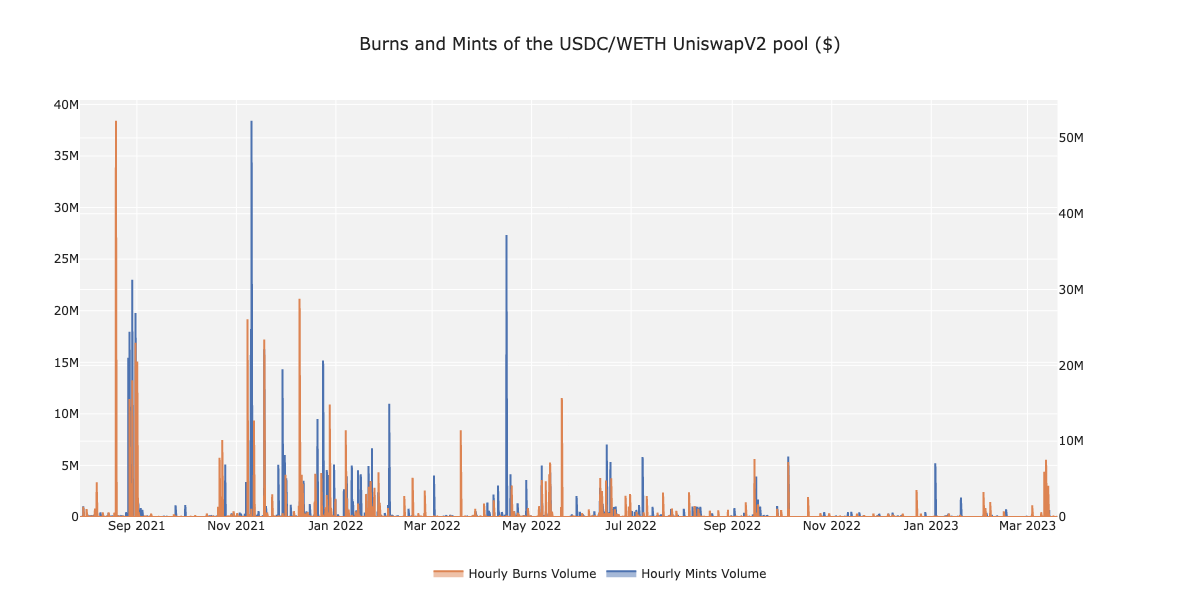

In [7]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    name="Hourly Mints Volume",
    x=df_mints_hour.index, y=df_mints_hour['volume'],
    mode='lines', stackgroup='one'
), secondary_y=False)

fig.add_trace(go.Scatter(
    name="Hourly Burns Volume",
    x=df_burns_hour.index, y=df_burns_hour['volume'],
    mode='lines', stackgroup='one'
), secondary_y=True)

fig.update_yaxes(secondary_y=False)
fig.update_yaxes(secondary_y=True)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Burns and Mints of the {pair_upper} UniswapV2 pool ($)")

fig.update_layout(width=1200, height=600)
fig.show("png")

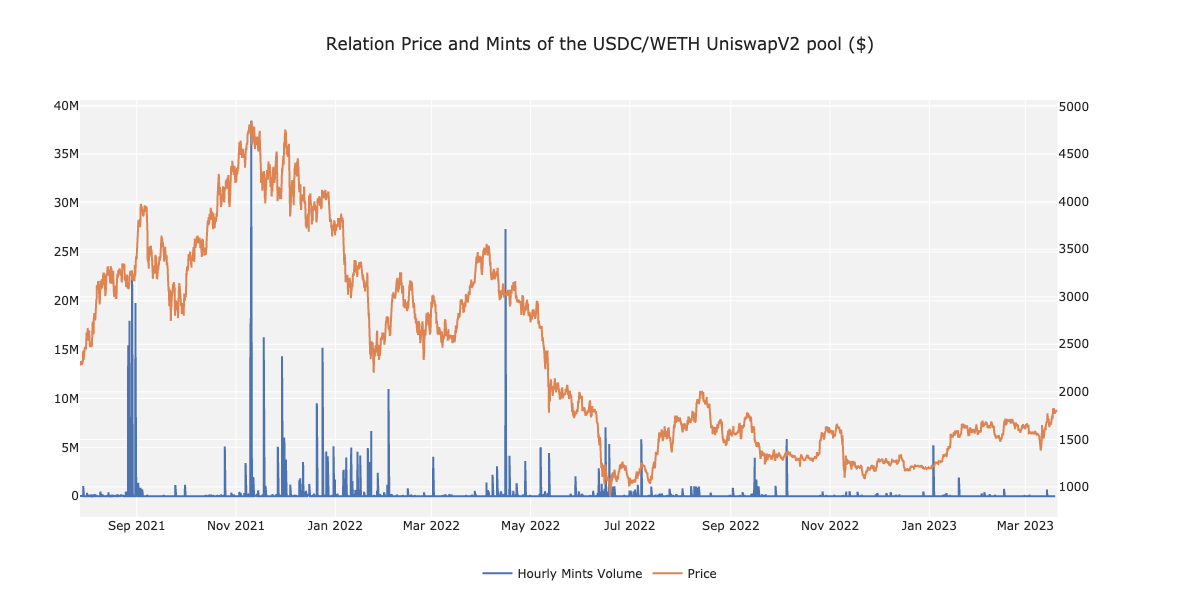

In [8]:
if pair == "usdc_weth":
    fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(
        name="Hourly Mints Volume",
        x=df_mints_hour.index, y=df_mints_hour['volume'],
        mode='lines'
    ), secondary_y=False)

    fig.add_trace(go.Scatter(
        name="Price",
        x=df_hour.index, y=df_hour['USDC_WETH_real_price'],
        mode='lines'
    ), secondary_y=True)

    fig.update_yaxes(secondary_y=False)
    fig.update_yaxes(secondary_y=True)
    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
    fig.update_layout(title=f"Relation Price and Mints of the {pair_upper} UniswapV2 pool ($)")
    fig.update_layout(width=1200, height=600)
    fig.show("png")

In [9]:
if pair == "usdc_weth":
    df_mints_day = df_mints_hour.groupby(pd.Grouper(freq="D")).agg({'USDC_WETH_real_price': 'mean', 'volume': 'sum'})
    df_mints_day["USDC_WETH_real_price_change"] = np.log(df_mints_day["USDC_WETH_real_price"]).diff(periods=1)
    df_mints_day_volume = df_mints_day[df_mints_day["volume"] != 0] # Remove non volume to not influence corr
    print("Correlation WETH/USDC Price and Mints:", df_mints_day_volume["volume"].corr(df_mints_day_volume['USDC_WETH_real_price']))
    print("Correlation WETH/USDC log return and Mints:", df_mints_day_volume["volume"].corr(df_mints_day_volume['USDC_WETH_real_price_change']))

Correlation WETH/USDC Price and Mints: 0.2032661885726921
Correlation WETH/USDC log return and Mints: -0.047332121711759


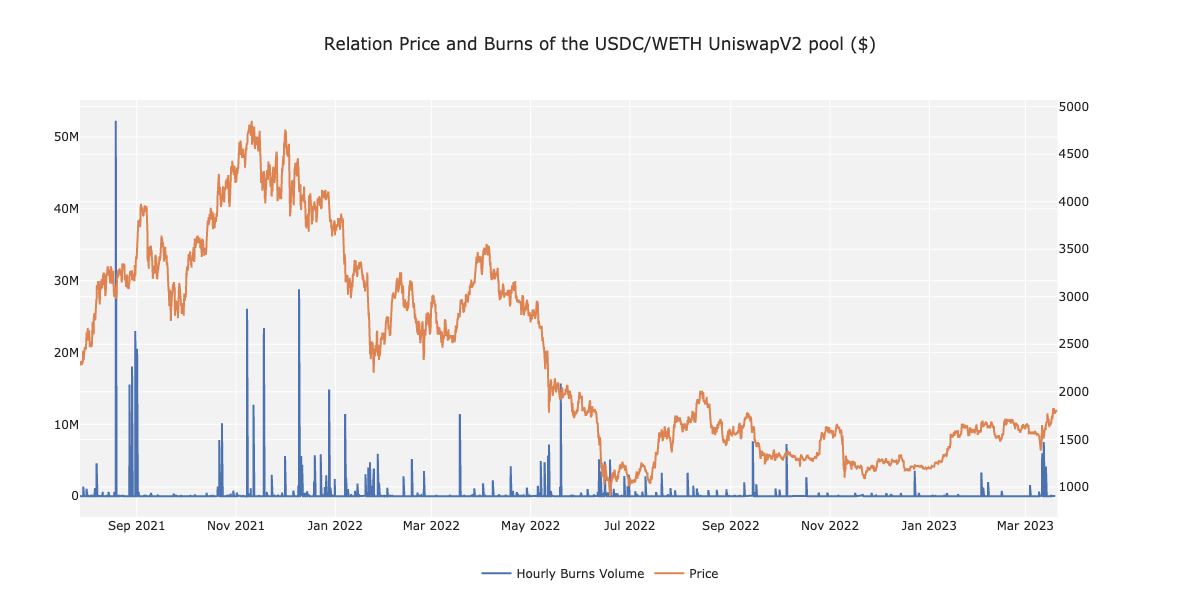

In [10]:
if pair == "usdc_weth":
    fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(
        name="Hourly Burns Volume",
        x=df_burns_hour.index, y=df_burns_hour['volume'],
        mode='lines'
    ), secondary_y=False)

    fig.add_trace(go.Scatter(
        name="Price",
        x=df_hour.index, y=df_hour['USDC_WETH_real_price'],
        mode='lines'
    ), secondary_y=True)

    fig.update_yaxes(secondary_y=False)
    fig.update_yaxes(secondary_y=True)
    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
    fig.update_layout(title=f"Relation Price and Burns of the {pair_upper} UniswapV2 pool ($)")
    fig.update_layout(width=1200, height=600)
    fig.show("png")

In [11]:
if pair == "usdc_weth":
    df_burns_day = df_burns_hour.groupby(pd.Grouper(freq="D")).agg({'USDC_WETH_real_price': 'mean', 'volume': 'sum'})
    df_burns_day["USDC_WETH_real_price_change"] = np.log(df_burns_day["USDC_WETH_real_price"]).diff(periods=1)
    df_burns_day_volume = df_burns_day[df_burns_day["volume"] != 0]
    print("Correlation WETH/USDC Price and Burns:", df_burns_day_volume["volume"].corr(df_burns_day_volume['USDC_WETH_real_price']))
    print("Correlation WETH/USDC log return and Burns:", df_burns_day_volume["volume"].corr(df_burns_day_volume['USDC_WETH_real_price_change']))

Correlation WETH/USDC Price and Burns: 0.1568026491663954
Correlation WETH/USDC log return and Burns: -0.06286476941313997


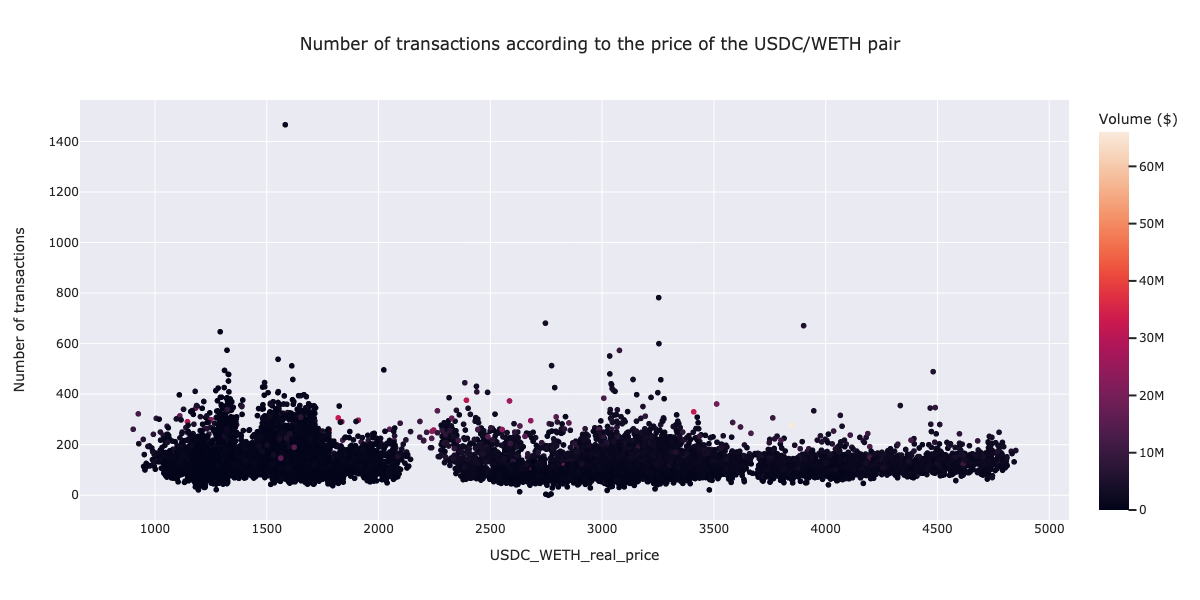

In [12]:
if pair == "usdc_weth":
    fig = px.scatter(df_swaps_hour, x=f"USDC_WETH_real_price", y="transaction_hash", color='trading_volume',
                    labels={
                        f"{pair_upper}_real_price": "ETH price ($)",
                        "transaction_hash": "Number of transactions",
                        "trading_volume": "Volume ($)"
                    },
                    title="Number of transactions according to the price of the USDC/WETH pair")
    fig.update_layout(width=1200, height=600)
    fig.show("png")

In [13]:
if pair == "usdc_weth":
    df_swaps_day = df_swaps_hour.groupby(pd.Grouper(freq="D")).agg({'USDC_WETH_real_price': 'mean', 'trading_volume': 'sum'})
    df_swaps_day["USDC_WETH_real_price_change"] = np.log(df_swaps_day["USDC_WETH_real_price"]).diff(periods=1)
    df_swaps_day_volume = df_swaps_day[df_swaps_day["trading_volume"] != 0]
    print()
    print("Correlation WETH/USDC Price and Swap Volume:", df_swaps_day_volume["trading_volume"].corr(df_swaps_day_volume['USDC_WETH_real_price']))
    print("Correlation WETH/USDC log return and Swap Volume:", df_swaps_day_volume["trading_volume"].corr(df_swaps_day_volume['USDC_WETH_real_price_change']))


Correlation WETH/USDC Price and Swap Volume: 0.47364173130335985
Correlation WETH/USDC log return and Swap Volume: -0.32983625771169856


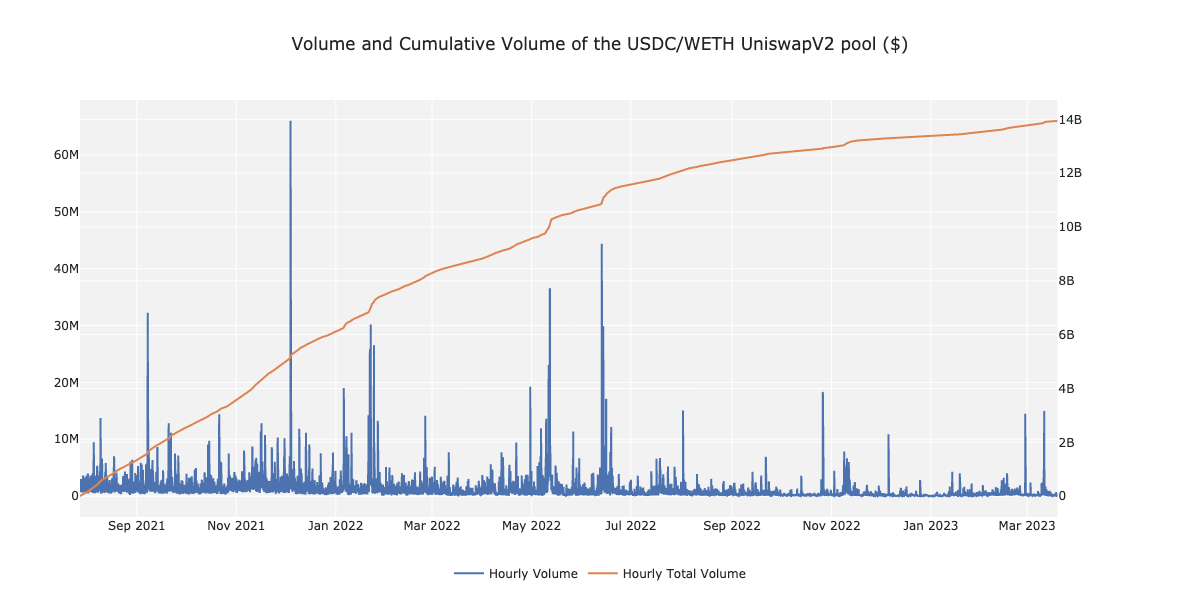

In [14]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    name="Hourly Volume",
    x=df_swaps_hour.index, y=df_swaps_hour['trading_volume'],
    mode='lines'
), secondary_y=False)

fig.add_trace(go.Scatter(
    name="Hourly Total Volume",
    x=df_swaps_hour.index, y=df_swaps_hour['trading_volume'].cumsum(),
    mode='lines'
), secondary_y=True)

fig.update_yaxes(secondary_y=False)
fig.update_yaxes(secondary_y=True)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Volume and Cumulative Volume of the {pair_upper} UniswapV2 pool ($)")
fig.update_layout(width=1200, height=600)
fig.show("png")

In [15]:
df_swaps_hour["trading_volume_fees"] = df_swaps_hour["trading_volume"] * 0.003

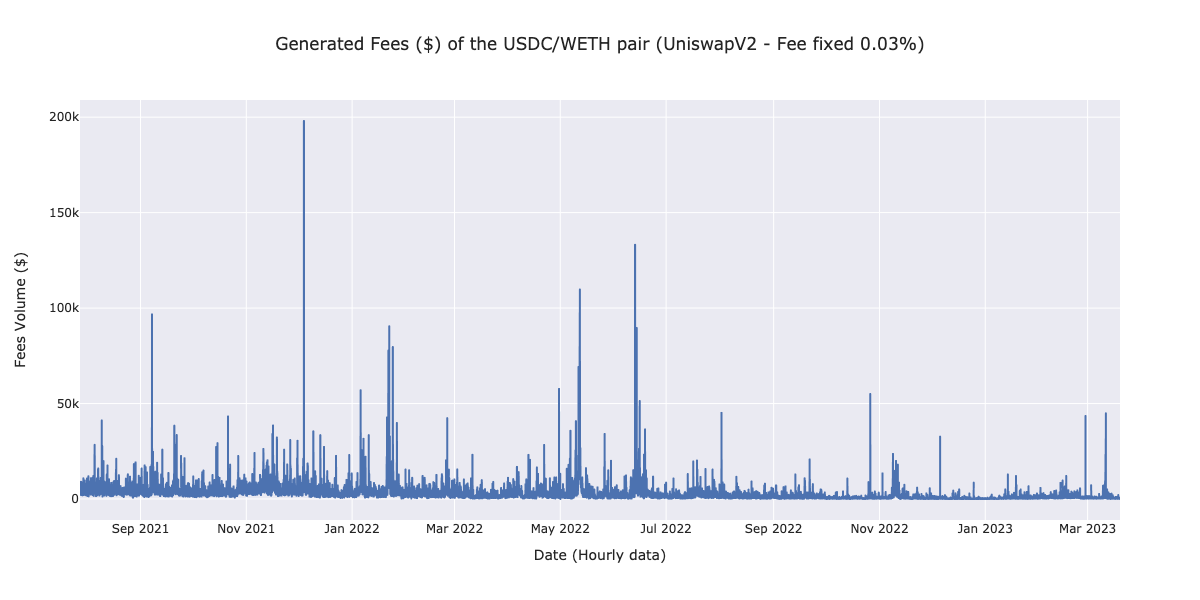

In [16]:
fig = px.line(df_swaps_hour, y="trading_volume_fees",
            labels={
                "trading_volume_fees": "Fees Volume ($)",
                "timestamp": "Date (Hourly data)",
            },
            title=f"Generated Fees ($) of the {pair_upper} pair (UniswapV2 - Fee fixed 0.03%)")
fig.update_layout(width=1200, height=600)
fig.show("png")

In [17]:
if pair == "usdc_usdt":
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        name="Hourly USDC Reserve",
        x=df_hour.index, y=df_hour['USDC_USDT_price'],
        mode='lines'
    ))

    fig.add_trace(go.Scatter(
        name="Hourly USDT Reserve",
        x=df_hour.index, y=df_hour['USDT_USDC_price'],
        mode='lines'
    ))

    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
    fig.update_layout(title=f"{pair_upper} Price UniswapV2 pool")
    fig.show()

In [18]:
df_hour["pool_yield_granular"] = 100 * df_swaps_hour["trading_volume_fees"] / df_hour["TVL"]
df_hour["pool_yield_cumsum"] = df_hour["pool_yield_granular"].cumsum()

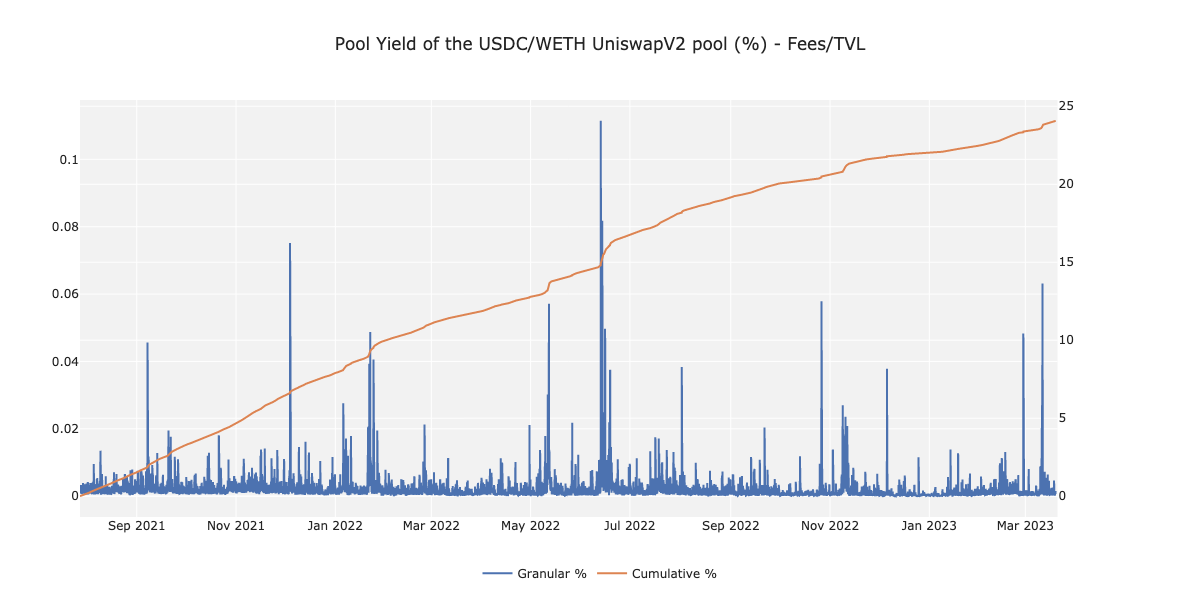

In [19]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    name="Granular %",
    x=df_hour.index, y=df_hour['pool_yield_granular'],
    mode='lines'
), secondary_y=False)

fig.add_trace(go.Scatter(
    name="Cumulative %",
    x=df_hour.index, y=df_hour['pool_yield_cumsum'],
    mode='lines'
), secondary_y=True)

fig.update_yaxes(secondary_y=False)
fig.update_yaxes(secondary_y=True)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Pool Yield of the {pair_upper} UniswapV2 pool (%) - Fees/TVL")
fig.update_layout(width=1200, height=600)
fig.show("png")

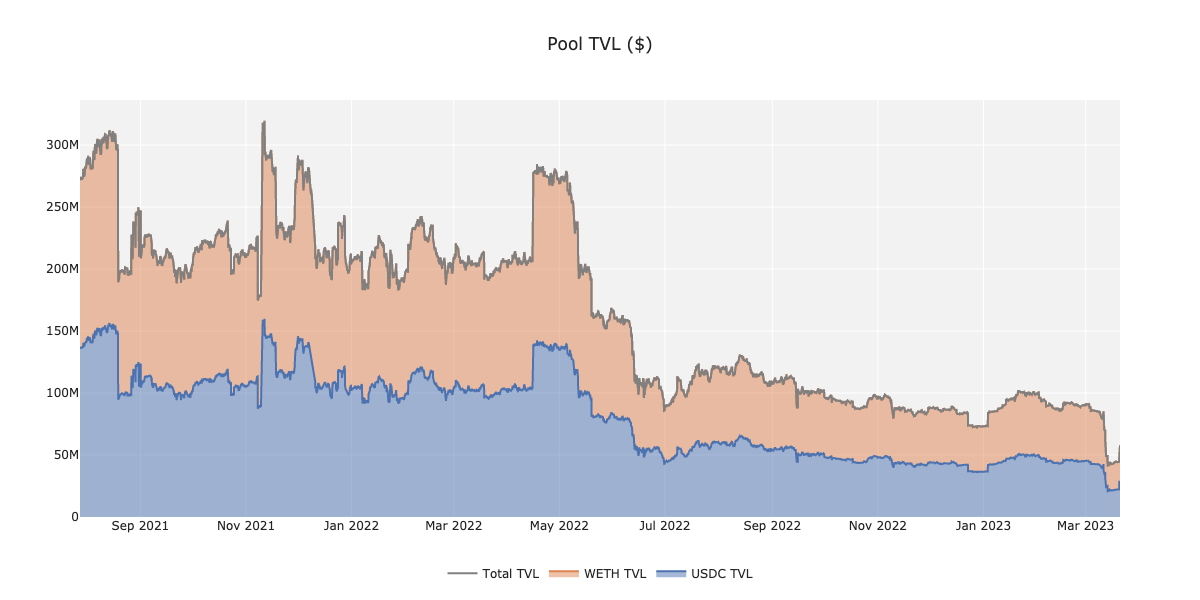

In [20]:
if pair == "usdc_weth":
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        name="USDC TVL",
        x=df_hour.index, y=df_hour['USDC_reserve'],
        mode='lines',
        stackgroup='one',
    ))

    fig.add_trace(go.Scatter(
        name="WETH TVL",
        x=df_hour.index, y=df_hour['WETH_reserve'] * df_hour['USDC_WETH_real_price'],
        mode='lines',
        stackgroup='one'
    ))

    fig.add_trace(go.Scatter(
        name="Total TVL",
        x=df_hour.index, y=df_hour['USDC_reserve'] + df_hour['WETH_reserve'] * df_hour['USDC_WETH_real_price'],
        mode='lines', line=dict(color="grey")
    ))

    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
    fig.update_layout(title="Pool TVL ($)")
    fig.update_layout(width=1200, height=600)
    fig.show("png")

In [21]:
df_hour["USDC_WETH_real_price_change"] = np.log(df_hour["USDC_WETH_real_price"]).diff(periods=1)
print()
print("Correlation WETH/USDC Price and TVL:", df_hour["TVL"].corr(df_hour['USDC_WETH_real_price']))
print("Correlation WETH/USDC log return and TVL:", df_hour["TVL"].corr(df_hour['USDC_WETH_real_price_change']))


Correlation WETH/USDC Price and TVL: 0.8503134616998157
Correlation WETH/USDC log return and TVL: 0.0006352788610458635


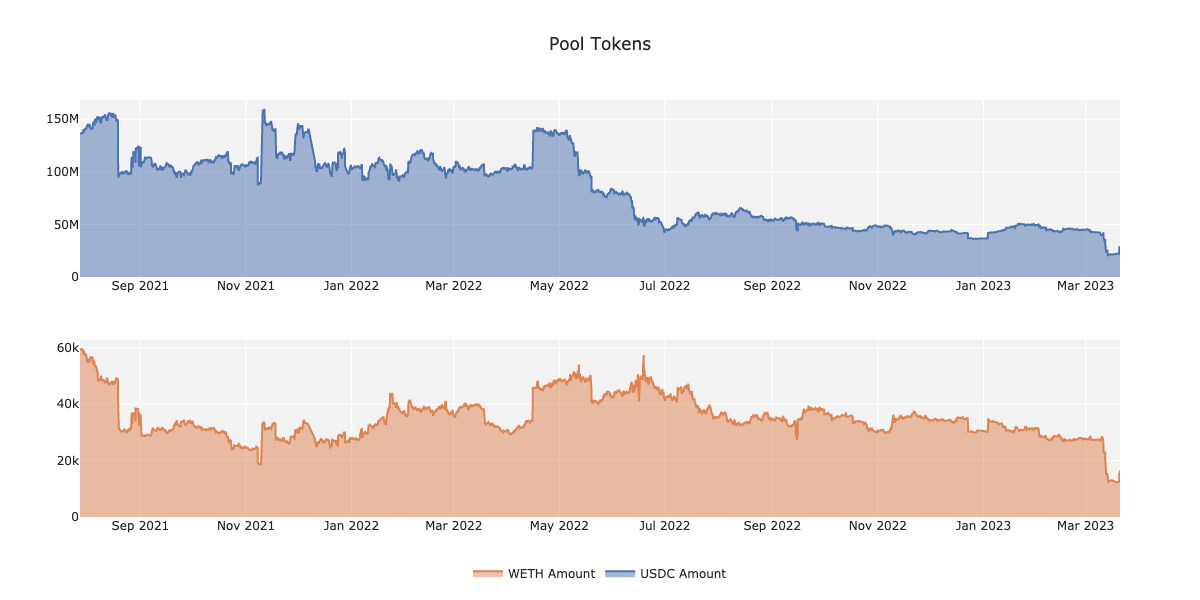

In [22]:
if pair == "usdc_weth":
    fig = make_subplots(rows=2)

    fig.add_trace(go.Scatter(
        name="USDC Amount",
        x=df_hour.index, y=df_hour['USDC_reserve'],
        mode='lines',
        stackgroup='one',
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        name="WETH Amount",
        x=df_hour.index, y=df_hour['WETH_reserve'],
        mode='lines',
        stackgroup='one'
    ), row=2, col=1)

    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
    fig.update_layout(title="Pool Tokens")

    fig.update_layout(width=1200, height=600)
    fig.show("png")

In [23]:
print("Correlation WETH/USDC Price and USDC reserve:", df_hour["USDC_reserve"].corr(df_hour['USDC_WETH_real_price']))
print("Correlation WETH/USDC Price and WETH reserve:", df_hour["WETH_reserve"].corr(df_hour['USDC_WETH_real_price']))

Correlation WETH/USDC Price and USDC reserve: 0.8501537181039188
Correlation WETH/USDC Price and WETH reserve: -0.24806296192654959


# Uniswap V2 transition to Uniswap V3

In [24]:
df_pool_stats = pd.read_csv(os.path.join(DATADIR, f'pool_stats_{pair}_uniswapV3.csv'), index_col=0)
df_swaps_v3 = load_data(f'swaps_{pair}_uniswapV3.csv')

df_pool_stats = df_pool_stats.merge(df_swaps_v3[["timestamp", "block_number"]], on="block_number")
#df_swaps.replace(['0', 0], np.nan, inplace=True)
df_swaps_v3[['amount0', 'amount1']] = df_swaps_v3[['amount0', 'amount1']].astype(float)

df_burns_v3 = load_data(f'burns_{pair}_uniswapV3.csv')
#df_burns[['amount0', 'amount1']] = df_burns[['amount0', 'amount1']].astype(float)
df_mints_v3 = load_data(f'mints_{pair}_uniswapV3.csv')
#df_mints[['amount0', 'amount1']] = df_mints[['amount0', 'amount1']].astype(float)

df_burns_hour_v3 = df_burns_v3.groupby(pd.Grouper(key="timestamp", freq="H")).agg({'amount0': 'sum', 'amount1': 'sum', 'transaction_hash':'count'})
df_mints_hour_v3 = df_mints_v3.groupby(pd.Grouper(key="timestamp", freq="H")).agg({'amount0': 'sum', 'amount1': 'sum', 'transaction_hash':'count'})
df_swaps_hour_v3 = df_swaps_v3.groupby(pd.Grouper(key="timestamp", freq="H")).agg({'amount0': 'sum', 'amount1': 'sum', 'liquidity':'mean', 'transaction_hash':'count'})

df_burns_hour_v3 = df_burns_hour_v3[df_burns_hour_v3.index > FILTER_DATE]
df_mints_hour_v3 = df_mints_hour_v3[df_mints_hour_v3.index > FILTER_DATE]
df_swaps_hour_v3 = df_swaps_hour_v3[df_swaps_hour_v3.index > FILTER_DATE]

In [25]:
df_swaps_general = df_swaps_hour.merge(df_swaps_hour_v3, right_index=True, left_index=True)
df_swaps_general['swaps_v2'] = 100*df_swaps_general['transaction_hash_x'] / (df_swaps_general['transaction_hash_x'] + df_swaps_general['transaction_hash_y'])
df_swaps_general['swaps_v3'] = 100*df_swaps_general['transaction_hash_y'] / (df_swaps_general['transaction_hash_x'] + df_swaps_general['transaction_hash_y'])

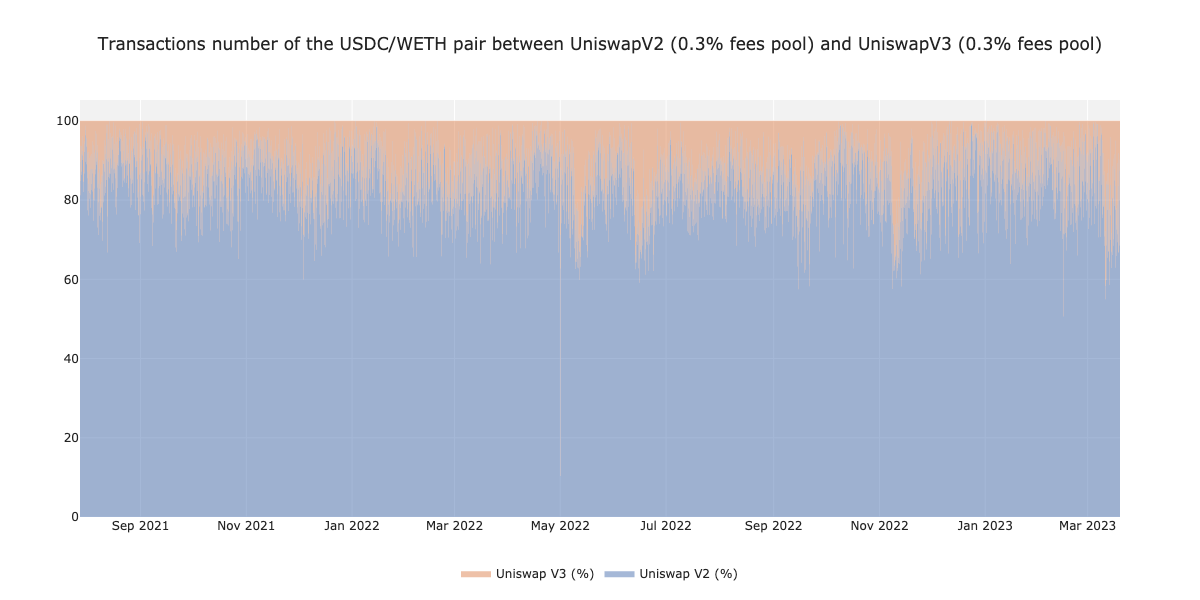

In [26]:
fig = go.Figure()
fig = make_subplots()

fig.add_trace(go.Scatter(
    name="Uniswap V2 (%)",
    x=df_swaps_general.index, y=df_swaps_general['swaps_v2'],
    stackgroup='one', line=dict(width=0)
))

fig.add_trace(go.Scatter(
    name="Uniswap V3 (%)",
    x=df_swaps_general.index, y=df_swaps_general['swaps_v3'],
    stackgroup='one', line=dict(width=0)
))

fig.update_yaxes(secondary_y=False)
fig.update_yaxes(secondary_y=True)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Transactions number of the {pair_upper} pair between UniswapV2 (0.3% fees pool) and UniswapV3 (0.3% fees pool)")
fig.update_layout(width=1200, height=600)
fig.show("png")

In [27]:
df_pool_stats['liquidity_eth'] = df_pool_stats['liquidity_hex'].apply(lambda x: int(x, 0)/ 10**18)
df_pool_stats['slot0_sqrt_price'] = df_pool_stats['slot0_sqrt_price_x96_hex'].apply(lambda x: int(x, 0) / 2**96)

In [28]:
def get_amount_in_eth(amount0, amount1, price):
    if (amount0 > 0):
            amount_in = amount0 / 10**18
    elif (amount1 > 0):
        amount_in = price * amount1 / 10**18
    else:
        amount_in = 0
    return amount_in

def get_amount_in(amount0, amount1):
    if (amount0 > 0):
        amount_in = amount0 / 10**4
    elif (amount1 > 0):
        amount_in = amount1 / 10**4
    else:
        amount_in = 0
    return amount_in

if pair == "usdc_weth":
    df_swaps_hour_v3 = df_swaps_hour_v3.merge(df_swaps_hour[["USDC_WETH_real_price"]], left_index=True, right_index=True)
    df_swaps_hour_v3['amount_in'] = df_swaps_hour_v3.apply(lambda x: get_amount_in_eth(x["amount0"],x["amount1"], x["USDC_WETH_real_price"]), axis=1)
elif pair == "usdc_usdt":
    df_swaps_hour_v3['amount_in'] = df_swaps_hour_v3.apply(lambda x: get_amount_in(x["amount0"],x["amount1"]), axis=1)


In [29]:
df_swaps_general = df_swaps_hour_v3[['amount_in']].merge(df_swaps_hour[['trading_volume']], left_index=True, right_index=True)
df_swaps_general["swaps_vol_v3"] = 100 * df_swaps_general["amount_in"] / (df_swaps_general["amount_in"] + df_swaps_general["trading_volume"])
df_swaps_general["swaps_vol_v2"] = 100 * df_swaps_general["trading_volume"] / (df_swaps_general["amount_in"] + df_swaps_general["trading_volume"])
df_swaps_general_day = df_swaps_general.groupby(pd.Grouper(freq="D")).agg({'swaps_vol_v3': 'mean', 'swaps_vol_v2': 'mean'})

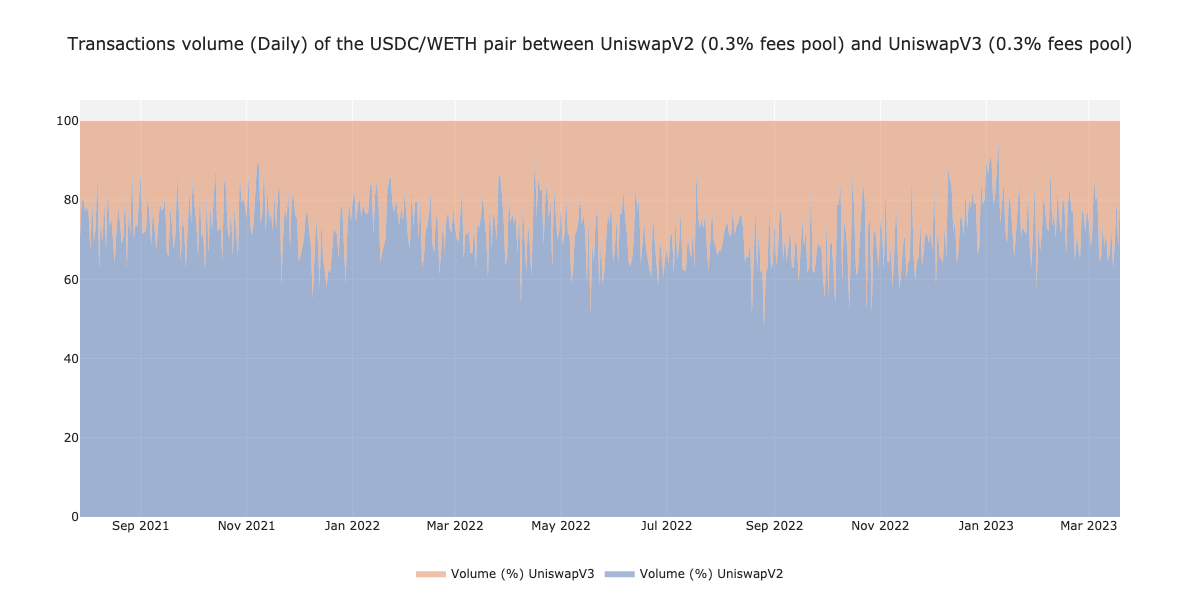

In [30]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Volume (%) UniswapV2",
    x=df_swaps_general_day.index, y=df_swaps_general_day['swaps_vol_v2'],
    stackgroup='one', line=dict(width=0)
))

fig.add_trace(go.Scatter(
    name="Volume (%) UniswapV3",
    x=df_swaps_general_day.index, y=df_swaps_general_day['swaps_vol_v3'],
    stackgroup='one', line=dict(width=0)
))

fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Transactions volume (Daily) of the {pair_upper} pair between UniswapV2 (0.3% fees pool) and UniswapV3 (0.3% fees pool)")
fig.update_layout(width=1200, height=600)
fig.show("png")

In [31]:
df_swaps_hour_v3["amount_in_cumsum"] = df_swaps_hour_v3["amount_in"].cumsum()

In [32]:
df_unique_users_v2 = df_swaps.drop_duplicates(subset=["sender", "to_address"], keep='first')
df_users_v2 = df_unique_users_v2.groupby(pd.Grouper(key="timestamp", freq="D")).agg({'transaction_hash':'count'})

## Users analysis

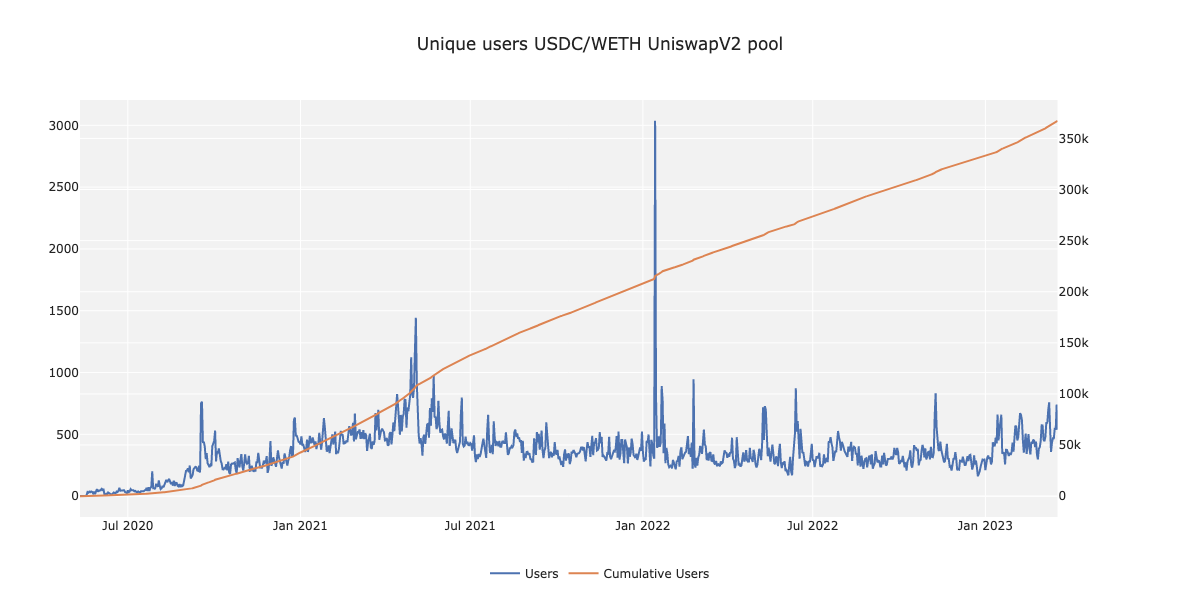

In [33]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    name="Users",
    x=df_users_v2.index, y=df_users_v2['transaction_hash'],
    mode='lines'
), secondary_y=False)

fig.add_trace(go.Scatter(
    name="Cumulative Users",
    x=df_users_v2.index, y=df_users_v2['transaction_hash'].cumsum(),
    mode='lines'
), secondary_y=True)

fig.update_yaxes(secondary_y=False)
fig.update_yaxes(secondary_y=True)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Unique users {pair_upper} UniswapV2 pool")
fig.update_layout(width=1200, height=600)
fig.show("png")

In [34]:
df_unique_users_v3 = df_swaps_v3.drop_duplicates(subset=["sender", "recipient"], keep='first')
df_users_v3 = df_unique_users_v3.groupby(pd.Grouper(key="timestamp", freq="D")).agg({'transaction_hash':'count'})

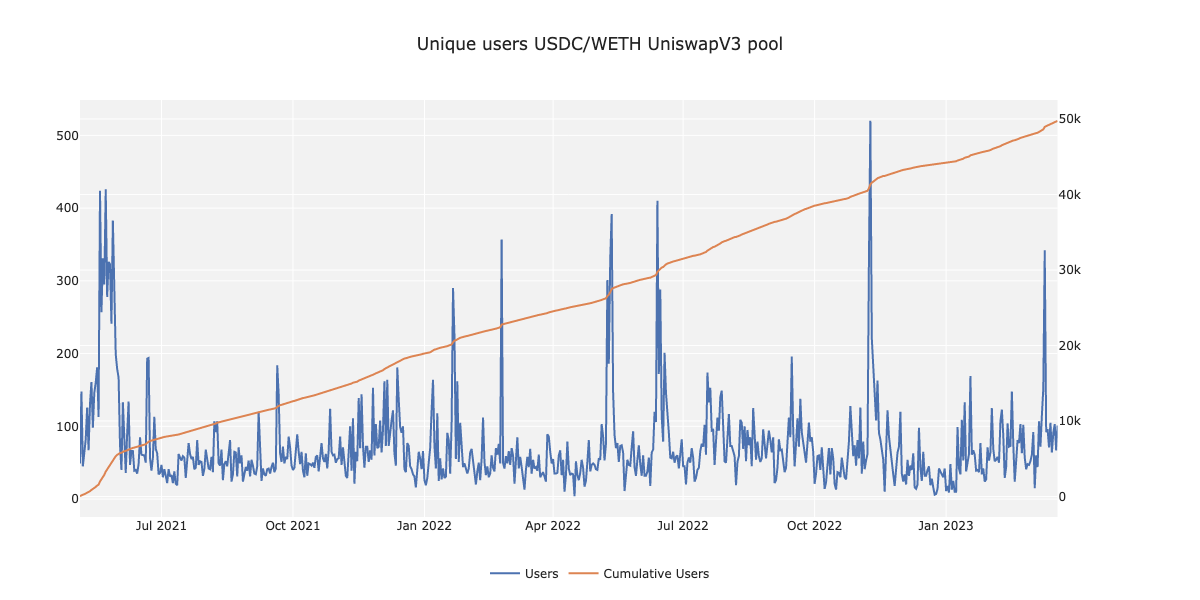

In [35]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    name="Users",
    x=df_users_v3.index, y=df_users_v3['transaction_hash'],
    mode='lines'
), secondary_y=False)

fig.add_trace(go.Scatter(
    name="Cumulative Users",
    x=df_users_v3.index, y=df_users_v3['transaction_hash'].cumsum(),
    mode='lines'
), secondary_y=True)

fig.update_yaxes(secondary_y=False)
fig.update_yaxes(secondary_y=True)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Unique users {pair_upper} UniswapV3 pool")
fig.update_layout(width=1200, height=600)
fig.show("png")

In [36]:
df_users = df_users_v3.merge(df_users_v2, left_index=True, right_index=True)

In [37]:
df_users["users_v3"] = df_users["transaction_hash_x"] / (df_users["transaction_hash_y"] + df_users["transaction_hash_x"])
df_users["users_v2"] = df_users["transaction_hash_y"] / (df_users["transaction_hash_y"] + df_users["transaction_hash_x"])

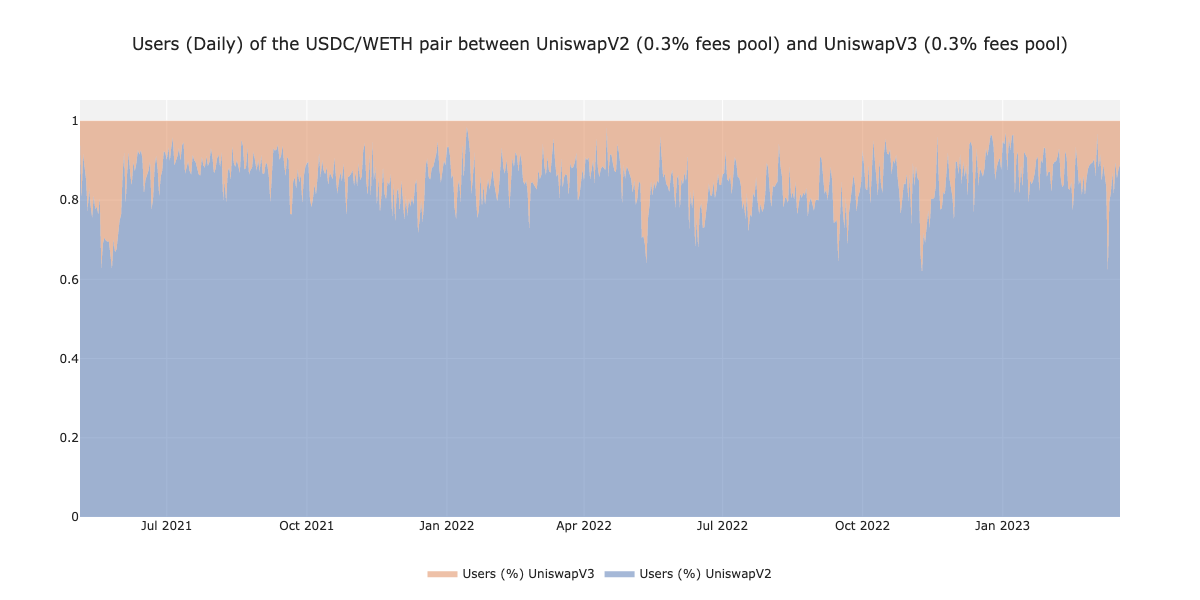

In [38]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Users (%) UniswapV2",
    x=df_users.index, y=df_users['users_v2'],
    stackgroup='one', line=dict(width=0)
))

fig.add_trace(go.Scatter(
    name="Users (%) UniswapV3",
    x=df_users.index, y=df_users['users_v3'],
    stackgroup='one', line=dict(width=0)
))

fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Users (Daily) of the {pair_upper} pair between UniswapV2 (0.3% fees pool) and UniswapV3 (0.3% fees pool)")
fig.update_layout(width=1200, height=600)
fig.show("png")

In [39]:
ranges = ['0-1', '1-10', '10-100', '>100']
df_users_swaps_v3 = df_swaps_v3.groupby(["sender", "recipient"], as_index=False).agg({'transaction_hash':'count'}).sort_values('transaction_hash')
transaction_count = pd.cut(df_users_swaps_v3['transaction_hash'], bins=[0, 1, 10, 100, float('inf')], labels=ranges).value_counts()
df_transaction_count = pd.DataFrame(transaction_count)

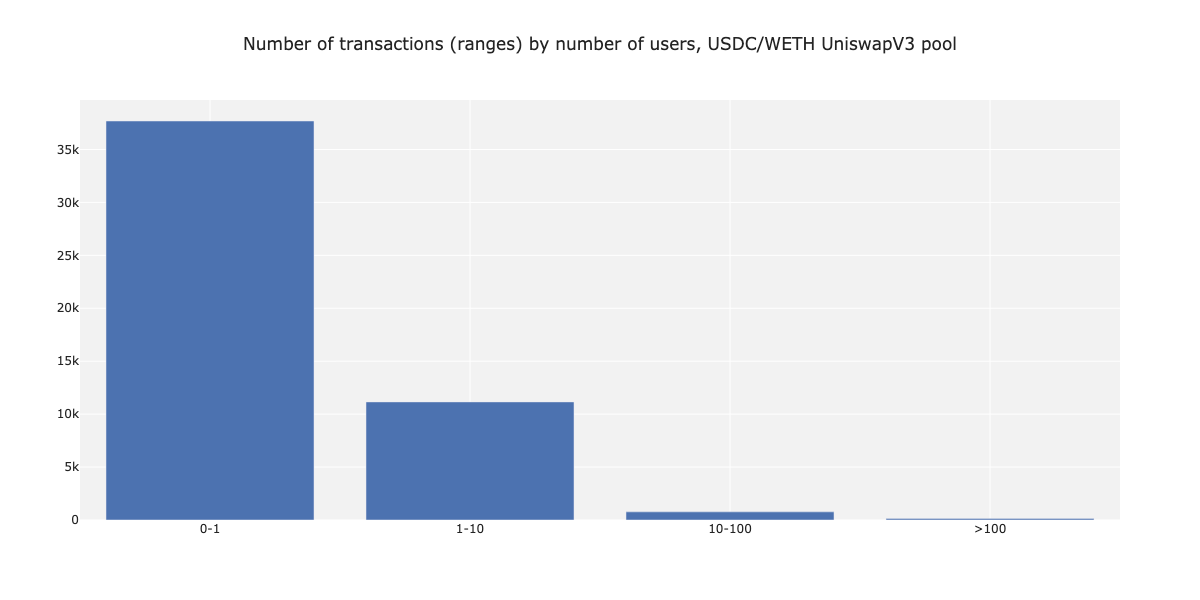

In [40]:
fig = go.Figure(data=[go.Bar(name="Number of users", x=df_transaction_count.index, y=df_transaction_count.transaction_hash)])
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Number of transactions (ranges) by number of users, {pair_upper} UniswapV3 pool")
fig.update_layout(width=1200, height=600)
fig.show("png")

In [41]:
df_users_swaps_v2 = df_swaps.groupby(["sender", "to_address"], as_index=False).agg({'transaction_hash':'count'}).sort_values('transaction_hash')
transaction_count = pd.cut(df_users_swaps_v2['transaction_hash'], bins=[0, 1, 10, 100, float('inf')], labels=ranges).value_counts()
df_transaction_count = pd.DataFrame(transaction_count)

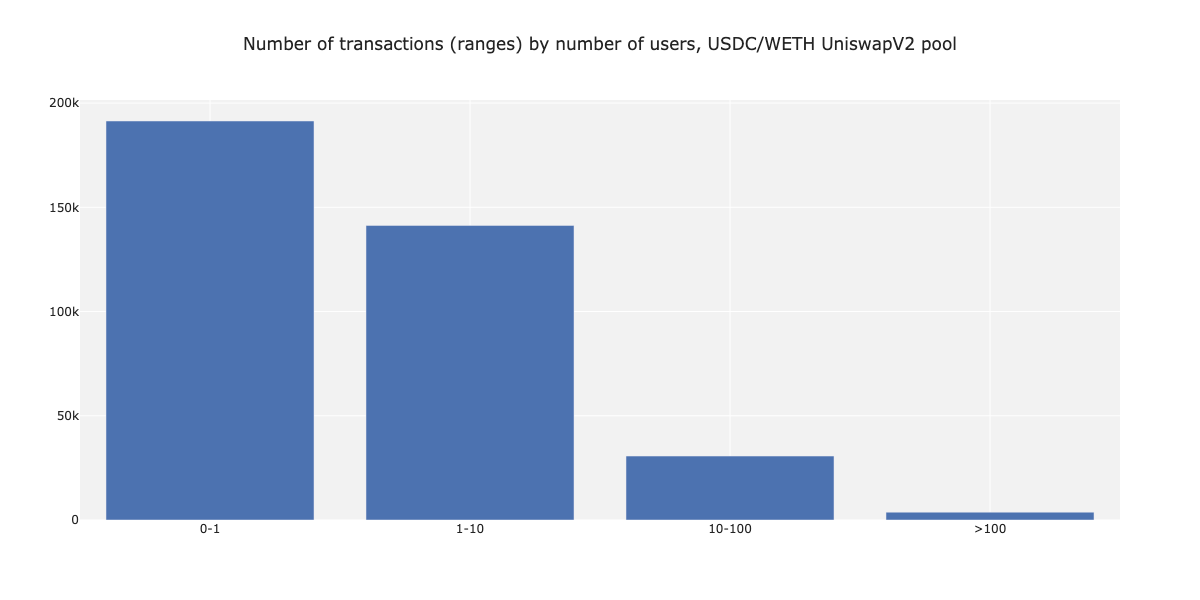

In [42]:
fig = go.Figure(data=[go.Bar(name="Number of users", x=df_transaction_count.index, y=df_transaction_count.transaction_hash)])
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_layout(title=f"Number of transactions (ranges) by number of users, {pair_upper} UniswapV2 pool")
fig.update_layout(width=1200, height=600)
fig.show("png")

# Modeling UniswapV2
Predict USDC/WETH pool on UniswapV2 thanks to mints, burns, swaps, TVL and other created features for the next 7 days using SARIMAX algorithm

In [43]:
df_mints_burns = df_burns_hour[["transaction_hash", "volume"]].merge(df_mints_hour[["transaction_hash", "volume"]], left_index=True, right_index=True, suffixes=["_burns", "_mints"])

In [44]:
df_events = df_mints_burns.merge(df_swaps_hour[["transaction_hash", "trading_volume", "trading_volume_fees"]], left_index=True, right_index=True)

In [45]:
df_model = df_events.merge(df_hour[["USDC_reserve", "WETH_reserve", "TVL", "pool_yield_granular", "USDC_WETH_real_price"]], left_index=True, right_index=True)

In [46]:
df_model_day = df_model.groupby(pd.Grouper(freq="D")).agg({'transaction_hash_burns': 'sum', 'volume_burns': 'sum',
                                            'transaction_hash_mints': 'sum', 'volume_mints': 'sum',
                                            'transaction_hash':'sum', 'trading_volume':'sum', 'trading_volume_fees':'sum',
                                            'USDC_reserve': 'mean', 'WETH_reserve': 'mean', 'TVL':'mean', 'pool_yield_granular':'mean',
                                            'USDC_WETH_real_price':'mean'})

df_model_day = df_model_day.merge(df_users_v2, left_index=True, right_index=True, suffixes=["_swaps", "_users"])

In [47]:
X = df_model_day[["transaction_hash_burns", "volume_burns", "transaction_hash_mints", "volume_mints", "transaction_hash_swaps",
                "trading_volume", "trading_volume_fees", "USDC_reserve", "WETH_reserve", "TVL", "pool_yield_granular", "transaction_hash_users"]]
y = df_model_day[["USDC_WETH_real_price"]]

In [48]:
import statsmodels.api as sm

In [51]:
model = sm.tsa.SARIMAX(y.to_numpy(), exog=X.to_numpy(), order=(4, 1, 1), seasonal_order=(1, 0, 1, 12))
results = model.fit()
print('Prediction per day for the next 7 days')
pred = results.predict(start=len(y), end=len(y)+6, exog=X[-7:])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.04777D+00    |proj g|=  1.42680D+06


 This problem is unconstrained.
/Users/lucaordronneau/miniconda3/envs/general/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20      1     21      1     0     0   1.427D+06   5.048D+00
  F =   5.0477732259640433     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Prediction per day for the next 7 days


In [52]:
pred

array([1682.55352047, 1760.07351894, 1738.45876225, 1725.39879692,
       1760.54444714, 1785.18886275, 1772.37149908])